In [318]:
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

In [319]:
path = kagglehub.dataset_download("gratefuldata/intraday-stock-data-1-min-sp-500-200821")+"/1_min_SPY_2008-2021.csv"
df = pd.read_csv(path)
df.head()

,Unnamed: 0,date,open,high,low,close,volume,barCount,average
0,0,20090522 07:30:00,89.45,89.46,89.37,89.37,7872,2102,89.424
1,1,20090522 07:31:00,89.38,89.53,89.37,89.50,5336,1938,89.468
2,2,20090522 07:32:00,89.51,89.54,89.48,89.49,3349,1184,89.516
3,3,20090522 07:33:00,89.49,89.49,89.31,89.34,3495,1240,89.386
4,4,20090522 07:34:00,89.33,89.46,89.33,89.39,9731,2637,89.379


*About The Data*

In [320]:
df.drop("Unnamed: 0", axis=1, inplace=True) #unused column

In [321]:
df.isnull().sum()

date        0
open        0
high        0
low         0
close       0
volume      0
barCount    0
average     0
dtype: int64

No null values

In [322]:
df.describe()

,open,high,low,close,volume,barCount,average
count,2.070834e+06,2.070834e+06,2.070834e+06,2.070834e+06,2.070834e+06,2.070834e+06,2.070834e+06
mean,2.090970e+02,2.091476e+02,2.090460e+02,2.090970e+02,2.703771e+03,8.388165e+02,2.090969e+02
std,8.408773e+01,8.409520e+01,8.407992e+01,8.408770e+01,3.826367e+03,9.743847e+02,8.408758e+01
min,6.712000e+01,6.720000e+01,6.710000e+01,6.712000e+01,0.000000e+00,0.000000e+00,6.715200e+01
25%,1.331400e+02,1.331700e+02,1.331000e+02,1.331400e+02,6.590000e+02,2.760000e+02,1.331390e+02
50%,2.028800e+02,2.029300e+02,2.028300e+02,2.028800e+02,1.503000e+03,5.480000e+02,2.028800e+02
75%,2.776300e+02,2.777000e+02,2.775700e+02,2.776300e+02,3.265000e+03,1.055000e+03,2.776340e+02
max,4.206700e+02,4.207200e+02,4.204000e+02,4.206700e+02,3.312820e+05,3.024500e+04,4.205350e+02


Values not normalized

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070834 entries, 0 to 2070833
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   open      float64
 2   high      float64
 3   low       float64
 4   close     float64
 5   volume    int64  
 6   barCount  int64  
 7   average   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 126.4+ MB


Over 2M rows-too much

In [324]:
df=df.iloc[:10_000] #reduce to 10,000 

*Clean The Data + Feature Engineering*

In [325]:
df['date'] = pd.to_datetime(df['date'])

In [326]:
df['hour']=df['date'].dt.hour
df['minute']=df['date'].dt.minute
df['daytime']=np.where(df['hour']<12,1,np.where(df ['hour']<17,2,3))

More relevant time columns

In [327]:
df['mean5']=np.mean(np.array([df['close'].shift(1),df['close'].shift(2),df['close'].shift(3),df['close'].shift(4),df['close'].shift(5)]),axis=0)
df['std5']=np.std(np.array([df['close'].shift(1),df['close'].shift(2),df['close'].shift(3),df['close'].shift(4),df['close'].shift(5)]),axis=0)
df['average5']=np.mean(np.array([df['average'].shift(1),df['average'].shift(2),df['average'].shift(3),df['average'].shift(4),df['average'].shift(5)]),axis=0)
df['barCount5']=np.mean(np.array([df['barCount'].shift(1),df['barCount'].shift(2),df['barCount'].shift(3),df['barCount'].shift(4),df['barCount'].shift(5)]),axis=0)

Columns about the past 5 minutes

In [328]:
df['rate']=df['close']/df['high'].shift(1)
df['up/down']=np.where(df['close']>df['high'].shift(1),1,0)

In [329]:
df['rate1']=df['high'].shift(-1)/df['close']-1
df['rate2']=df['high'].shift(-2)/df['close']-1
df['rate3']=df['high'].shift(-3)/df['close']-1
df['rate4']=df['high'].shift(-4)/df['close']-1
df['rate5']=df['high'].shift(-5)/df['close']-1


In [330]:
df['target']=np.max(np.array([df['rate1'],df['rate2'],df['rate3'],df['rate4'],df['rate5']]),axis=0)

Predict the maximum return for the next 5 minutes~

In [331]:
df=df[5:-5] #remove null values
df

,date,open,high,low,close,volume,barCount,average,hour,minute,...,average5,barCount5,rate,up/down,rate1,rate2,rate3,rate4,rate5,target
5,2009-05-22 07:35:00,89.38,89.41,89.17,89.18,8546,2366,89.273,7,35,...,89.4346,1820.2,0.996870,0,0.001794,0.002803,0.001794,0.000785,0.000449,0.002803
6,2009-05-22 07:36:00,89.18,89.34,89.18,89.33,9047,2244,89.248,7,36,...,89.4044,1873.0,0.999105,0,0.001119,0.000112,-0.000896,-0.001231,-0.001119,0.001119
7,2009-05-22 07:37:00,89.33,89.43,89.21,89.21,11989,3368,89.326,7,37,...,89.3604,1934.2,0.998545,0,0.001457,0.000448,0.000112,0.000224,-0.000336,0.001457
8,2009-05-22 07:38:00,89.21,89.34,89.19,89.21,7399,2251,89.254,7,38,...,89.3224,2371.0,0.997540,0,0.000448,0.000112,0.000224,-0.000336,-0.001794,0.000448
9,2009-05-22 07:39:00,89.21,89.25,89.12,89.15,11346,2828,89.196,7,39,...,89.2960,2573.2,0.997873,0,0.000785,0.000897,0.000337,-0.001122,-0.002019,0.000897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,2015-09-09 07:30:00,199.34,199.39,199.15,199.16,11676,2652,199.273,7,30,...,218.5908,2383.4,0.910945,0,0.000653,0.000402,0.000753,0.000552,0.001155,0.001155
9991,2015-09-09 07:31:00,199.17,199.29,199.17,199.23,5701,1964,199.231,7,31,...,214.7292,2626.8,0.999198,0,0.000050,0.000402,0.000201,0.000803,0.001004,0.001004
9992,2015-09-09 07:32:00,199.24,199.24,199.11,199.24,4751,1665,199.164,7,32,...,210.8598,2677.0,0.999749,0,0.000351,0.000151,0.000753,0.000954,0.001154,0.001154
9993,2015-09-09 07:33:00,199.23,199.31,199.16,199.17,3468,1189,199.255,7,33,...,206.9724,2677.8,0.999649,0,0.000502,0.001105,0.001305,0.001506,0.000954,0.001506


(array([7801.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2189.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

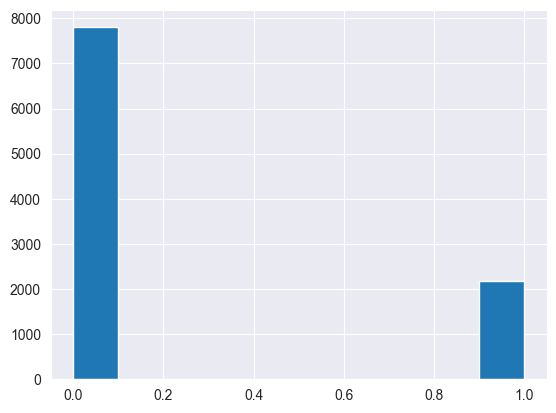

In [332]:
plt.hist(df['up/down'])

Most of the time s&p500 is increasing

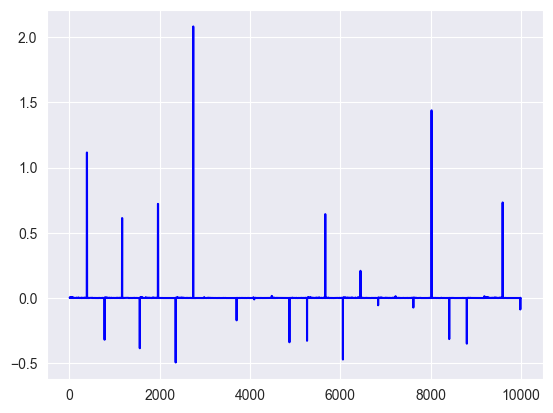

In [333]:
plt.plot(df['target'],color='blue',label='Expected Max Return Rate For The Next 5 Minutes')

<Axes: xlabel='hour', ylabel='target'>

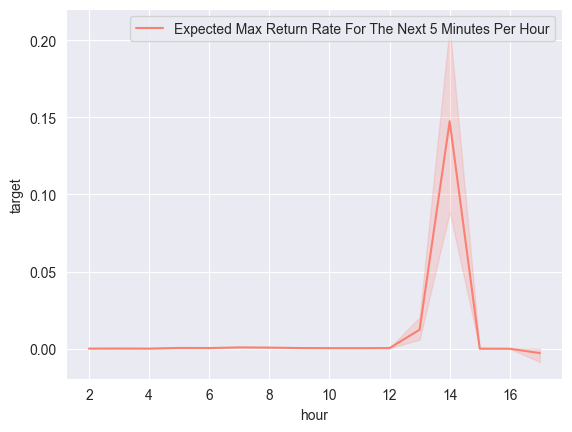

In [334]:
sns.lineplot(x=df['hour'],y=df['target'],color='salmon',label='Expected Max Return Rate For The Next 5 Minutes Per Hour')

Between 12-15 the return is the best

<Axes: xlabel='hour', ylabel='rate'>

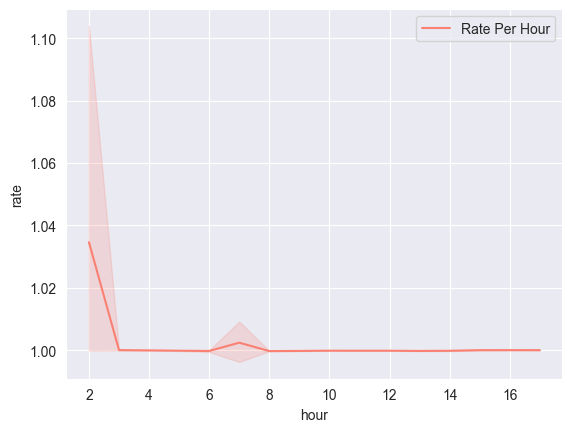

In [335]:
sns.lineplot(x=df['hour'],y=df['rate'],color='salmon',label='Rate Per Hour')

<Axes: ylabel='average'>

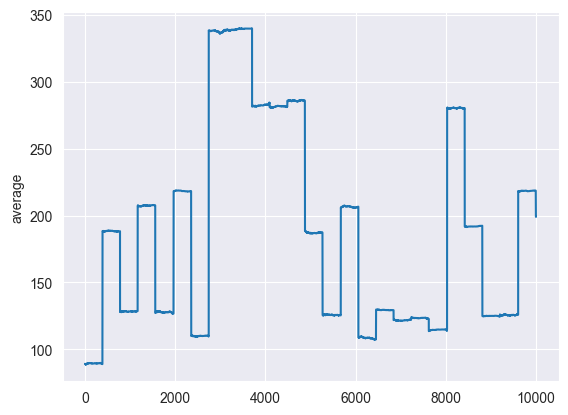

In [336]:
sns.lineplot(df['average'])

<Axes: ylabel='barCount'>

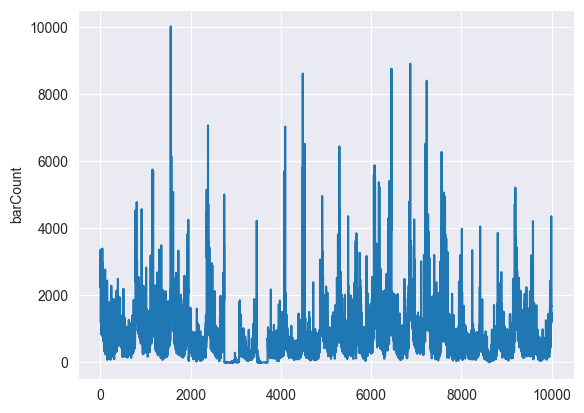

In [337]:
sns.lineplot(df['barCount'])

<Axes: xlabel='hour', ylabel='std5'>

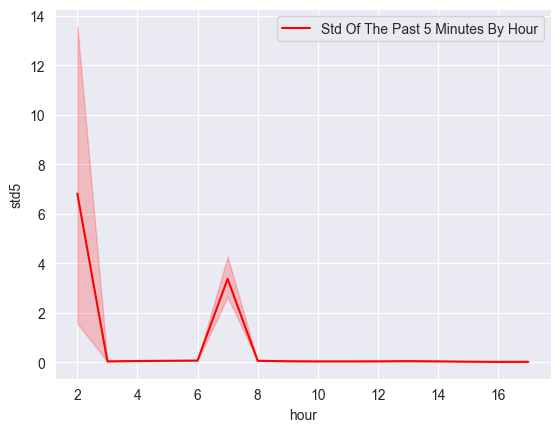

In [338]:
sns.lineplot(x=df['hour'],y=df['std5'],color='red',label='Std Of The Past 5 Minutes By Hour')

At morning the std rate increases

In [339]:
df.describe()

,date,open,high,low,close,volume,barCount,average,hour,minute,...,average5,barCount5,rate,up/down,rate1,rate2,rate3,rate4,rate5,target
count,9990,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.00000,9990.000000,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,2013-12-04 09:34:21.891891712,188.608779,188.646585,188.570376,188.608924,2793.064665,805.419019,188.60847,10.183183,30.400901,...,188.575497,805.496677,1.000182,0.219119,0.000652,0.001069,0.001486,0.001903,0.002320,0.003997
min,2008-07-18 07:30:00,88.690000,88.850000,88.680000,88.690000,0.000000,0.000000,88.76000,2.000000,0.000000,...,88.802400,0.000000,0.505225,0.000000,-0.494339,-0.494431,-0.494568,-0.495302,-0.495256,-0.494339
25%,2010-01-29 09:12:15,124.980000,125.000000,124.960000,124.980000,725.250000,299.250000,124.98100,9.000000,15.000000,...,124.988200,358.250000,0.999600,0.000000,0.000053,0.000000,-0.000071,-0.000104,-0.000154,0.000146
50%,2014-05-01 11:49:30,187.250000,187.300000,187.200000,187.250000,1661.000000,570.000000,187.24150,10.000000,31.000000,...,187.212400,618.000000,0.999841,0.000000,0.000154,0.000157,0.000160,0.000160,0.000160,0.000355
75%,2018-07-19 07:51:45,279.840000,279.900000,279.785000,279.840000,3565.750000,1051.000000,279.84400,12.000000,45.000000,...,279.807350,1025.900000,1.000000,0.000000,0.000318,0.000400,0.000458,0.000493,0.000547,0.000717
max,2020-08-21 17:59:00,339.670000,339.720000,339.670000,339.680000,44856.000000,10024.000000,339.67000,17.000000,59.000000,...,339.658000,5658.600000,3.078569,1.000000,2.082916,2.080911,2.080273,2.080091,2.079818,2.082916
std,NaN,77.255819,77.256484,77.255844,77.256587,3458.403793,794.178052,77.25596,2.318489,17.334546,...,77.181521,681.324607,0.032756,0.413670,0.032789,0.046351,0.056751,0.065519,0.073234,0.069823


In [340]:
scaler=MinMaxScaler()
for col in ['open','close','high','low','volume','barCount','average','mean5','std5','average5','barCount5','rate']:
    df[col]=scaler.fit_transform(df[col].values.reshape(-1,1))
df.describe()
    

,date,open,high,low,close,volume,barCount,average,hour,minute,...,average5,barCount5,rate,up/down,rate1,rate2,rate3,rate4,rate5,target
count,9990,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,2013-12-04 09:34:21.891891712,0.398115,0.397802,0.397985,0.398099,0.062267,0.080349,0.397945,10.183183,30.400901,...,0.397731,0.142349,0.192340,0.219119,0.000652,0.001069,0.001486,0.001903,0.002320,0.003997
min,2008-07-18 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.494339,-0.494431,-0.494568,-0.495302,-0.495256,-0.494339
25%,2010-01-29 09:12:15,0.144593,0.144099,0.144548,0.144587,0.016168,0.029853,0.144359,9.000000,15.000000,...,0.144250,0.063311,0.192114,0.000000,0.000053,0.000000,-0.000071,-0.000104,-0.000154,0.000146
50%,2014-05-01 11:49:30,0.392701,0.392434,0.392526,0.392685,0.037030,0.056864,0.392497,10.000000,31.000000,...,0.392297,0.109214,0.192208,0.000000,0.000154,0.000157,0.000160,0.000160,0.000160,0.000355
75%,2018-07-19 07:51:45,0.761614,0.761550,0.761405,0.761584,0.079493,0.104848,0.761564,12.000000,45.000000,...,0.761414,0.181299,0.192269,0.000000,0.000318,0.000400,0.000458,0.000493,0.000547,0.000717
max,2020-08-21 17:59:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,59.000000,...,1.000000,1.000000,1.000000,1.000000,2.082916,2.080911,2.080273,2.080091,2.079818,2.082916
std,NaN,0.307817,0.307954,0.307804,0.307807,0.077100,0.079228,0.307903,2.318489,17.334546,...,0.307673,0.120405,0.012729,0.413670,0.032789,0.046351,0.056751,0.065519,0.073234,0.069823


Values are scaled

In [341]:
df.isnull().sum()

date         0
open         0
high         0
low          0
close        0
volume       0
barCount     0
average      0
hour         0
minute       0
daytime      0
mean5        0
std5         0
average5     0
barCount5    0
rate         0
up/down      0
rate1        0
rate2        0
rate3        0
rate4        0
rate5        0
target       0
dtype: int64

Still no null values after feature engineering

*Predict The target*

In [342]:
X=pd.DataFrame(df[['open','high','volume','mean5','std5','average5','barCount5','rate','hour','minute']])
Y=df['target']
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,shuffle=False)

In [343]:
model=xgb.XGBRegressor()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
rmse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 0.0016813048759162948
R2 Score: 0.7456627398930882


Good Model- 74% of data's std is explained by the model, very small error.

<Axes: >

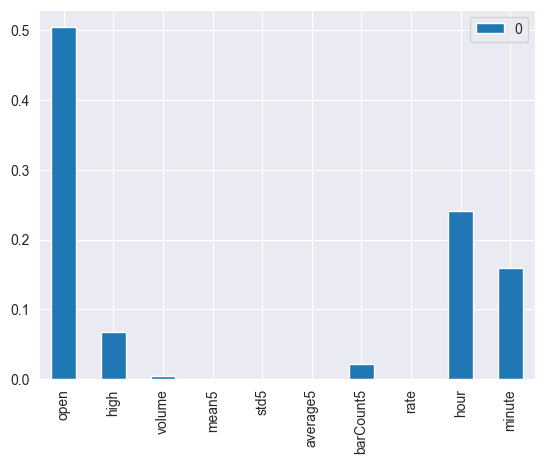

In [344]:
importance=pd.DataFrame(model.feature_importances_,index=X.columns)
importance.plot.bar()

Open, hour and minute columns contributes the most to the prediction